In [37]:
import serial
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Note 1: This python script was designed to run with Python 3.
#
# Note 2: The script uses "pyserial" which must be installed.  If you have
#         previously installed the "serial" package, it must be uninstalled
#         first.
#
# Note 3: While this script is running you can not re-program the Arduino.
#         Before downloading a new Arduino sketch, you must exit this
#         script first.
arduinoComPort = "COM5"


# Set the baud rate
# NOTE1: The baudRate for the sending and receiving programs must be the same!
# NOTE2: For faster communication, set the baudRate to 115200 below
#        and check that the arduino sketch you are using is updated as well.
baudRate = 9600


# open the serial port
serialPort = serial.Serial(arduinoComPort, baudRate, timeout=1)

tiltMin = 0
tiltMax = 170
tiltStep = 10
panMin = 0
panMax = 170
panStep = 10
numRows = int(((tiltMax-tiltMin)/tiltStep +1)*((panMax-panMin)/panStep +1))
ptsrData = [[0]*4] * numRows
# print(ptsrData)
# ptsrData.astype(int)
# print(ptsrData)

i = 0
# main loop to read data from the Arduino, then display it
while i < numRows:
    # print(ptsrData)
    # ask for a line of data from the serial port, the ".decode()" converts the
    # data from an "array of bytes", to a string
    lineOfData = serialPort.readline().decode()

    # check if data was received
    if len(lineOfData) > 0:
        # print(lineOfData)
        # print(len(lineOfData))

        if len(lineOfData) == 3:
            if int(lineOfData) == 1: # done with scan
                print(ptsrData)
                i = numRows
            elif int(lineOfData) == 0: # restarting scan
                ptsrData = np.zeros((numRows,4))
                i = 0
        else: # continue with this scan
            # data was received, convert it into 4 integers
            panPos, tiltPos, rotPos, dist = (int(x) for x in lineOfData.split(','))

            # # print the results
            # print("panPos = " + str(panPos), end="")
            # print(", tiltPos = " + str(tiltPos), end="")
            # print(", rotPos = " + str(rotPos), end="")
            # print(", dist = " + str(dist))
            print(panPos, tiltPos, dist, 0.0])
            ptsrData[i] = [panPos, tiltPos, dist, 0.0]
            i = i+1

[0, 0, 0, 59]
[10, 0, 0, 59]
[20, 0, 0, 59]
[30, 0, 0, 60]
[40, 0, 0, 60]
[50, 0, 0, 61]
[60, 0, 0, 79]
[70, 0, 0, 60]
[80, 0, 0, 48]
[90, 0, 0, 60]
[100, 0, 0, 60]
[110, 0, 0, 60]
[120, 0, 0, 60]
[130, 0, 0, 60]
[140, 0, 0, 59]
[150, 0, 0, 59]
[160, 0, 0, 60]
[170, 0, 0, 60]
[170, 10, 0, 60]
[160, 10, 0, 45]
[150, 10, 0, 60]
[140, 10, 0, 44]
[130, 10, 0, 60]
[120, 10, 0, 63]
[110, 10, 0, 77]
[100, 10, 0, 77]
[90, 10, 0, 79]
[80, 10, 0, 79]
[70, 10, 0, 77]
[60, 10, 0, 60]
[50, 10, 0, 61]
[40, 10, 0, 60]
[30, 10, 0, 60]
[20, 10, 0, 63]
[10, 10, 0, 56]
[0, 10, 0, 60]
[0, 20, 0, 78]
[10, 20, 0, 60]
[20, 20, 0, 64]
[30, 20, 0, 44]
[40, 20, 0, 44]
[50, 20, 0, 44]
[60, 20, 0, 60]
[70, 20, 0, 60]
[80, 20, 0, 60]
[90, 20, 0, 60]
[100, 20, 0, 60]
[110, 20, 0, 60]
[120, 20, 0, 59]
[130, 20, 0, 60]
[140, 20, 0, 44]
[150, 20, 0, 60]
[160, 20, 0, 48]
[170, 20, 0, 60]
[170, 30, 0, 59]
[160, 30, 0, 60]
[150, 30, 0, 59]
[140, 30, 0, 60]
[130, 30, 0, 59]
[120, 30, 0, 60]
[110, 30, 0, 59]
[100, 30, 0, 5

In [39]:
# print(ptsrData)
ptsrNP = np.array(ptsrData)
print(ptsrNP)


[[  0.   0.  59.   0.]
 [ 10.   0.  59.   0.]
 [ 20.   0.  59.   0.]
 ...
 [ 20. 170.  60.   0.]
 [ 10. 170.  59.   0.]
 [  0. 170.  60.   0.]]


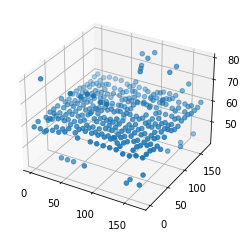

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(ptsrNP[:,0], ptsrNP[:,1], ptsrNP[:,2])


[-2.86458333e-06  7.18750000e-04 -6.01041667e-02  1.98750000e+00
  3.80000000e+01]
[[  0.           0.          59.          58.94486172]
 [ 10.           0.          59.          58.94486172]
 [ 20.           0.          59.          58.94486172]
 ...
 [ 20.         170.          60.          59.        ]
 [ 10.         170.          59.          58.94486172]
 [  0.         170.          60.          59.        ]]


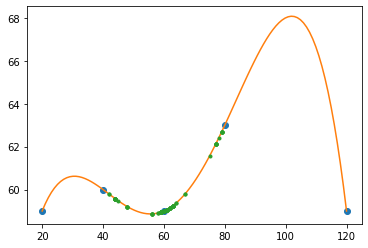

In [54]:
dsNP = np.load("calibration_data.npy")
# print(dsNP)


c = np.polyfit(dsNP[:,0],dsNP[:,1],len(dsNP[:,0])-1)
print(c)

xp = np.linspace(np.amin(dsNP[:,0]),np.amax(dsNP[:,0]), 100)
p = np.poly1d(c)

i = 0
while i < numRows:
    ptsrNP[i,3] = p(ptsrNP[i,2])
    i = i+1

print(ptsrNP)

fig = plt.figure()
ax = plt.axes()
plt.plot(dsNP[:,0],dsNP[:,1], 'o', xp, p(xp), '-',ptsrNP[:,2],ptsrNP[:,3],'.')

In [55]:
xyzData = [[0]*3] * numRows
xyzNP = np.array(xyzData)
j = 0
print(np.sin(np.radians(ptsrData[j][1])))
while j < numRows:
    xyzNP[j,0] = ptsrNP[j,3]*np.cos(np.radians(ptsrNP[j,0]))*np.cos(np.radians(ptsrNP[j,1]))
    xyzNP[j,2] = ptsrNP[j,3]*np.sin(np.radians(ptsrNP[j,0]))*np.cos(np.radians(ptsrNP[j,1]))
    xyzNP[j,1] = ptsrNP[j,3]*np.sin(np.radians(ptsrNP[j,1]))
    j = j+1

print(xyzNP)

0.0
[[ 58   0   0]
 [ 58   0  10]
 [ 55   0  20]
 [ 51   0  29]
 [ 45   0  37]
 [ 37   0  45]
 [ 31   0  54]
 [ 20   0  55]
 [ 10   0  58]
 [  0   0  58]
 [-10   0  58]
 [-20   0  55]
 [-29   0  51]
 [-37   0  45]
 [-45   0  37]
 [-51   0  29]
 [-55   0  20]
 [-58   0  10]
 [-57  10  10]
 [-55  10  20]
 [-50  10  29]
 [-44  10  37]
 [-37  10  44]
 [-29  10  50]
 [-20  10  57]
 [-10  10  60]
 [  0  10  61]
 [ 10  10  60]
 [ 20  10  57]
 [ 29  10  50]
 [ 37  10  44]
 [ 44  10  37]
 [ 50  10  29]
 [ 54  10  19]
 [ 57  10  10]
 [ 58  10   0]
 [ 58  21   0]
 [ 54  20   9]
 [ 52  20  19]
 [ 48  20  27]
 [ 42  20  35]
 [ 35  20  42]
 [ 27  20  48]
 [ 18  20  52]
 [  9  20  54]
 [  0  20  55]
 [ -9  20  54]
 [-18  20  52]
 [-27  20  47]
 [-35  20  42]
 [-42  20  35]
 [-48  20  27]
 [-52  20  19]
 [-54  20   9]
 [-50  29   8]
 [-48  29  17]
 [-44  29  25]
 [-39  29  32]
 [-32  29  39]
 [-25  29  44]
 [-17  29  47]
 [ -8  29  50]
 [  0  29  51]
 [  8  29  50]
 [ 17  29  48]
 [ 25  29  44]
 [ 32 

Text(0.5, 0, 'Y')

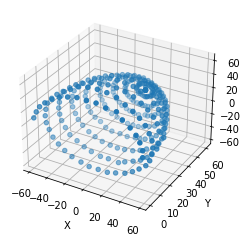

In [56]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xyzNP[:,0], xyzNP[:,1], xyzNP[:,2])
plt.xlabel("X")
plt.ylabel("Y")